In [40]:
import pandas as pd
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

**read List of postal codes of Canada from Wikipedia using pandas**

In [41]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url)[0]
df.head(12)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


**filter out rows with 'Not assigned' as value in Borough column**

In [42]:
df = df.loc[df['Borough'] != 'Not assigned']
df.reset_index(inplace=True)
del df['index']
df.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### print out the shape of the dataframe

In [44]:
print('shape of the dataframe: ', df.shape)

shape of the dataframe:  (103, 3)


*More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.*

**Obtain multiple rows, each with only 1 neighborhood, from postal code areas with multiple neighborhoods**

In [45]:
s = df['Neighborhood'].str.split(',').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'Neighborhood' 
del df['Neighborhood']
df = df.join(s)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Manor


**check if some row has 'Not assigned' as 'Neighborhood' value**

In [5]:
not_assigned_neighs = len(df.loc[df['Neighborhood'] == 'Not assigned'])
print('number of rows with not assinged neighborhood: ', not_assigned_neighs)

number of rows with not assinged neighborhood:  0


**if some row has not assigned neighborhood, the following replaces not assigned with borough value from the same row**

In [6]:
df['Neighborhood'] = df.apply(lambda row: row['Borough'] if row['Neighborhood'] == 'Not assigned' else row['Neighborhood'],axis=1)

**check again if now some row has 'Not assigned' as 'Neighborhood' value**

In [7]:
not_assigned_neighs = len(df.loc[df['Neighborhood'] == 'Not assigned'])
print('number of rows with not assinged neighborhood: ', not_assigned_neighs)

number of rows with not assinged neighborhood:  0


### print out the shape of the dataframe

In [8]:
print('shape of the dataframe: ', df.shape)

shape of the dataframe:  (217, 3)


**add neighborhood coordinates to df using csv at https://cocl.us/Geospatial_data**

In [9]:
df_coord = pd.read_csv('https://cocl.us/Geospatial_data')
df = pd.merge(df, df_coord, on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


**filter the dataset in order to maintain only boroughs that contain the word Toronto**

In [10]:
df = df.loc[df['Borough'].str.contains('Toronto')].reset_index()
del df['index']
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
1,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
2,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
3,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494
4,M5B,Downtown Toronto,Garden District,43.657162,-79.378937


**use geopy library to get the latitude and longitude values of Toronto.**

In [11]:
address = 'Toronto, TO'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**create map of toronto using lat and long values**

In [12]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**let's simplify the above map and segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.**

In [13]:
downtown_df = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
1,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
2,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
3,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494
4,M5B,Downtown Toronto,Garden District,43.657162,-79.378937


**visualize Downtown Toronto neighborhoods through Folium map**

In [14]:
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(downtown_df['Latitude'], downtown_df['Longitude'], downtown_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**function to get the top 100 venues within a radius of 500 meters that are in all the neighborhoods in Downtown Toronto**

In [16]:
CLIENT_ID = '4IZHTCZPM3W0P135TEVFVUVCJ1QHDHXHH3OIFJJZF3OWOWNN'
CLIENT_SECRET = 'HOCOCALVJLZRD3BGEZSMPY1IALR3MWYM0LUG5LWU0NVZQJMW'
VERSION = '20180605' 
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
downtown_venues = getNearbyVenues(names=downtown_df['Neighborhood'],
                                   latitudes=downtown_df['Latitude'],
                                   longitudes=downtown_df['Longitude']
                                  )

Regent Park
 Harbourfront
Queen's Park
 Ontario Provincial Government
Garden District
 Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond
 Adelaide
 King
Harbourfront East
 Union Station
 Toronto Islands
Toronto Dominion Centre
 Design Exchange
Commerce Court
 Victoria Hotel
University of Toronto
 Harbord
Kensington Market
 Chinatown
 Grange Park
CN Tower
 King and Spadina
 Railway Lands
 Harbourfront West
 Bathurst Quay
 South Niagara
 Island airport
Rosedale
Stn A PO Boxes
St. James Town
 Cabbagetown
First Canadian Place
 Underground city
Church and Wellesley


**check how many unique categories can be curated from all the returned venues**

In [18]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 213 uniques categories.


**perform one-hot-encoding in order to apply the KMeans Clustering algo**

In [19]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Neighborhood'] = downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
downtown_onehot.shape

(2404, 213)

**group rows by neighborhood and calculate mean of categories in that neighborhood**

In [21]:
downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()
downtown_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021053,...,0.0,0.0,0.00,0.010526,0.0,0.00,0.000000,0.0,0.0,0.010526
1,Bathurst Quay,0.0,0.0,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,...,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
2,Cabbagetown,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
3,Chinatown,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.050000,0.0,0.05,0.016667,0.0,0.0,0.000000
4,Design Exchange,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.0,0.0,0.01,0.010000,0.0,0.00,0.010000,0.0,0.0,0.000000


In [22]:
downtown_grouped.shape

(38, 213)

**check top 5 most common venues for each neighborhood**

In [23]:
num_top_venues = 5

for hood in downtown_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide----
           venue  freq
0    Coffee Shop  0.09
1     Restaurant  0.05
2           Café  0.05
3  Deli / Bodega  0.03
4          Hotel  0.03


---- Bathurst Quay----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3          Boutique  0.06
4   Harbor / Marina  0.06


---- Cabbagetown----
                venue  freq
0         Coffee Shop  0.06
1         Pizza Place  0.06
2          Restaurant  0.06
3                Café  0.06
4  Italian Restaurant  0.04


---- Chinatown----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.07
2             Mexican Restaurant  0.05
3          Vietnamese Restaurant  0.05
4  Vegetarian / Vegan Restaurant  0.05


---- Design Exchange----
                venue  freq
0         Coffee Shop  0.10
1               Hotel  0.07
2                Café  0.06
3          Restaurant  0.04
4  Italian Restaurant  0.03


---- Grange Park----

**put top 5 common venues for each neighborhood into a *pandas* dataframe**

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_grouped['Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Restaurant,Café,Gym,Thai Restaurant,Hotel,Clothing Store,Deli / Bodega,Bookstore,Cosmetics Shop
1,Bathurst Quay,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
2,Cabbagetown,Restaurant,Café,Pizza Place,Coffee Shop,Chinese Restaurant,Pub,Bakery,Italian Restaurant,Park,Convenience Store
3,Chinatown,Café,Coffee Shop,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Pizza Place,Bakery,Gaming Cafe,Park
4,Design Exchange,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Salad Place,Seafood Restaurant,Japanese Restaurant,Deli / Bodega,Italian Restaurant


### Elbow Method

**Represent performed clusters in order to choose the best number of clusters (K starting value for KMeans) using Elbow Method.**

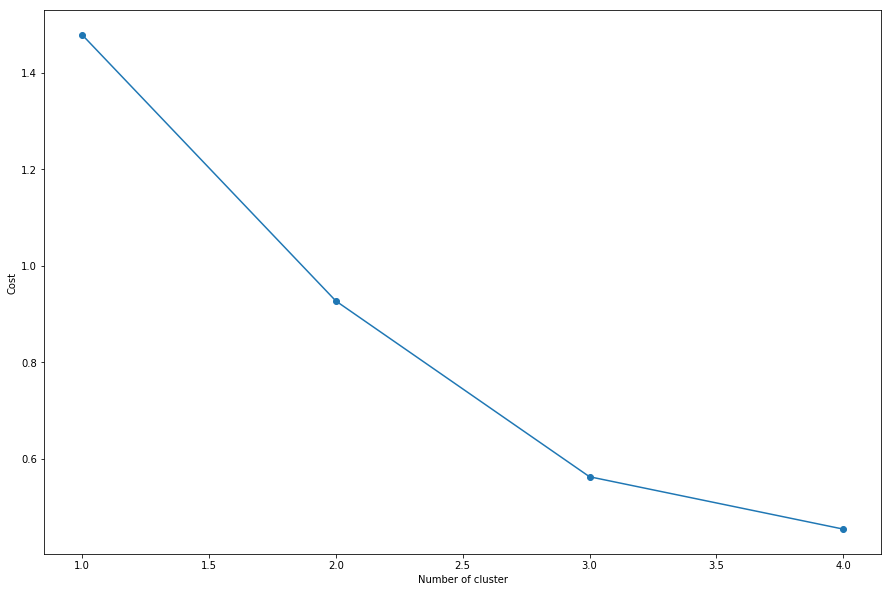

In [26]:
downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)

def n_clusters(last, df, km=[], res_clust=[], first=1):
    for n in range(first, last+1):
        n_clusters = n
        km.append(KMeans(n_clusters=n_clusters, random_state=0))
        res_clust.append(km[n-1].fit_predict(df))
        print( )
    return km, res_clust

centroids = []
km, clusters = n_clusters(5, downtown_grouped_clustering)

sse = {}
for k in range (1, len(km)):
    sse[k] = km[k-1].inertia_
fig = plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of cluster")
plt.ylabel("Cost")
plt.show()

### As shown by the chart, the best value (according with the Elbow Method) for initializing K is 3
**perform KMeans Clustering with K=3**

In [27]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

**add clustering information on Downtown Toronto df**

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = downtown_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Restaurant,Breakfast Spot,Event Space,Hotel
1,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Restaurant,Breakfast Spot,Event Space,Hotel
2,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Wings Joint
3,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Wings Joint
4,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,0,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Diner,Bakery


In [34]:
downtown_merged['Cluster Labels'].value_counts()

0    31
1     7
2     1
Name: Cluster Labels, dtype: int64

### Finally, let's visualize the resulting clusters using Folium maps

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighborhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Restaurant,Breakfast Spot,Event Space,Hotel
1,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Restaurant,Breakfast Spot,Event Space,Hotel
2,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Wings Joint
3,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Wings Joint
4,Downtown Toronto,0,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Diner,Bakery
5,Downtown Toronto,0,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Diner,Bakery
6,Downtown Toronto,0,Café,Coffee Shop,Restaurant,Italian Restaurant,Gastropub,Cocktail Bar,Park,Pizza Place,Bakery,American Restaurant
7,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Café,Bakery,Seafood Restaurant,Beer Bar,Restaurant,Cheese Shop,Japanese Restaurant,Shopping Mall
8,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place,Bubble Tea Shop,Burger Joint,Salad Place,Department Store,Poke Place
9,Downtown Toronto,0,Grocery Store,Café,Park,Nightclub,Restaurant,Candy Store,Italian Restaurant,Diner,Coffee Shop,Baby Store


In [31]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
26,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
27,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
28,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
29,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
30,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
31,Downtown Toronto,1,Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar


In [32]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Downtown Toronto,2,Park,Playground,Trail,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
